# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# Applying Logistic Regression

## Logistic Regression on BOW

### Applying Logistic Regression with L1 regularization on BOW

In [2]:

# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


## Data Cleaning : Deduplication

In [3]:

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries 
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

In [10]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ..."
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...


## Prerpocessing Review Text
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

Begin by removing the html tags Remove any punctuations or limited set of special characters like , or . or # etc. Check if the word is made up of english letters and is not alpha-numeric Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters) Convert the word to lowercase Remove Stopwords Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming) After which we collect the words used to describe positive and negative reviews

In [11]:
# Importing necessary libraries

from bs4 import BeautifulSoup
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [12]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [13]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)# To remove urls
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()# To remove numbers
    sentance = re.sub('[^A-Za-z]+', ' ', sentance) # To remove special characters
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)# To convert to lower case letters
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:40<00:00, 2154.43it/s]


In [14]:
# Adding a new column "Review_Text" to the "final" dataframe with the Text "preprocessed_reviews"

final["Review_Text"]=preprocessed_reviews

In [15]:
final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review_Text
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...


## Sorting the data in descenindg order based on Time Column

In [16]:
final=final.sort_values(by='Time',axis=0,ascending=False)

In [17]:
final.head(50)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review_Text
5259,5703,B009WSNWC4,AMP7K1O84DH1T,ESTY,0,0,1,1351209600,DELICIOUS,Purchased this product at a local store in NY ...,purchased product local store ny kids love qui...
1005,1089,B004FD13RW,A1BPLP0BKERV,Paul,0,0,1,1351209600,It is awesome.,"My partner is very happy with the tea, and is ...",partner happy tea feeling much better since st...
63160,68621,B005IOXBY0,A1ORVAUR5C5N8X,amondigirl,0,0,1,1351209600,WOW.....,This chocolate is amazing..I love the taste an...,chocolate amazing love taste smell chocolate f...
9513,10404,B005HI55CS,A36ERNIM0TKG3T,Donald E. Bolton,0,0,1,1351209600,Hidden Springs Maple syrup,This is one of the very finest maple syrups I ...,one finest maple syrups ordered enjoyed bought...
86066,93711,B001NZPFB0,A3318V6FJ2KIII,T. Dennis,0,0,1,1351209600,My dog enjoys it and it helps her hips.,My dog was diagnosed with hip dysplasia as a 6...,dog diagnosed hip dysplasia old puppy vet said...
30235,32932,B001P05K8Q,A3L0B5NBTQ7ZHO,Julie,0,0,1,1351209600,Great results but they stink,We originally purchased these chews from our v...,originally purchased chews veterinarian decide...
96778,105165,B005EF0HZ4,A2A5Z7LC91EFVA,Gretchen Casey,0,0,1,1351209600,Gluten Free Kid,We LOVE Lucy's cookies! The Maple Bliss are w...,love lucy cookies maple bliss wonderful bad ha...
96779,105166,B005EF0HZ4,A1JXSMYVHFPWM1,marsha m beers,0,0,0,1351209600,Disappointed,I have not been able to find the Maple flavor ...,not able find maple flavor cookies area anywhe...
39050,42397,B0014DXT5A,AZUCLRMHEBUG0,"T. HANLEY ""reader""",0,0,1,1351209600,ZipFizz liquid energy shot,Have used this for years. Gives long lasting ...,used years gives long lasting energy boost no ...
5472,5924,B00523NRVO,A2JDXKFZ0PFHKU,James W. Shondel,0,0,1,1351209600,The perfect pop!,"These lollipops are are well done, look exactl...",lollipops well done look exactly like picture ...


In [18]:
# Dropping unnecessary columns and keeping only Review_Text and Score Columns

final_df=final[['Review_Text','Score']]

In [19]:
final_df.shape

(87773, 2)

In [20]:
final_df.head()

,Review_Text,Score
5259,purchased product local store ny kids love qui...,1
1005,partner happy tea feeling much better since st...,1
63160,chocolate amazing love taste smell chocolate f...,1
9513,one finest maple syrups ordered enjoyed bought...,1
86066,dog diagnosed hip dysplasia old puppy vet said...,1


In [21]:
#Splitting the data into Features and Labels

X=final_df['Review_Text'].values
y=final_df['Score'].values

In [22]:
# Splitting the data into Training and Testing

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=3,shuffle=False) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.30,random_state=3,shuffle=False) # this is random splitting

In [23]:
# Shape of the Training and Test data

print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)



(43008,) (43008,)
(18433,) (18433,)
(26332,) (26332,)


In [24]:
# Converting to BOW

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)


print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)

After vectorizations
(43008, 38523) (43008,)
(18433, 38523) (18433,)
(26332, 38523) (26332,)


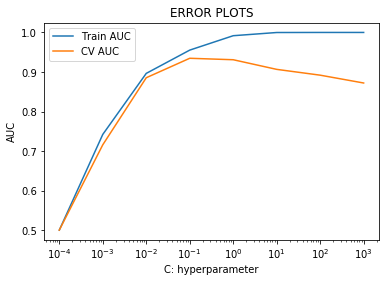

In [26]:
# Hyper parameter tuning to find best C
# Simple Cross validation

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
C = [10**-4,10**-3,10**-2,10**-1,1,10,100,1000]
for i in C:
    LR=LogisticRegression(C=i,penalty='l1',class_weight='balanced',random_state=2,n_jobs=-1)
    LR.fit(X_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  LR.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  LR.predict_proba(X_cv_bow)[:,1]
    y_test_pred =  LR.predict_proba(X_test_bow)[:,1]

    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
plt.semilogx(C, train_auc,label='Train AUC')
plt.semilogx(C, cv_auc,label='CV AUC')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

From the above plot,we can see that the best C value is 10^-1

## Scaling the vectorized data before applying Logistic Regression

In [27]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler(with_mean=False)
X_train_bow_std=sc.fit_transform(X_train_bow)
X_cv_bow_std=sc.transform(X_cv_bow)
X_test_bow_std=sc.transform(X_test_bow)

## Building Logistic Regression using best C value and L1 regilarization

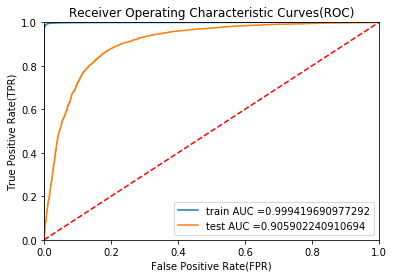

In [30]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
LR=LogisticRegression(C=10**-1,penalty='l1',class_weight='balanced',random_state=3,n_jobs=-1)
LR.fit(X_train_bow_std, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds_tr_bow = roc_curve(y_train, LR.predict_proba(X_train_bow_std)[:,1])
test_fpr, test_tpr, thresholds_te_bow = roc_curve(y_test, LR.predict_proba(X_test_bow_std)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()


In [31]:
# Finding the Weight vector(coefficients of features)

W=LR.coef_
W

array([[0., 0., 0., ..., 0., 0., 0.]])

In [32]:
# Finding Intercept
Intercept=LR.intercept_
Intercept


array([0.23247935])

In [33]:
# Finding the size of Weight vector
W.size

38523

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [34]:
#Calculating Sparsity

# https://stackoverflow.com/questions/38708621/how-to-calculate-percentage-of-sparsity-for-a-numpy-array-matrix

'''Sparsity=1-(count of non zero elements of weight vector/Total elements of weight vector)'''

from numpy import count_nonzero
print("Count of Non zeros :",count_nonzero(W))
print("Total elements :",W.size)
print("% of Non zero elements :",count_nonzero(W) / float(W.size)*100)# To see % of non zero elements
# calculate sparsity
sparsity = 1.0 - ( count_nonzero(W) / float(W.size) )
print("The sparsity is(1-% of Non zeros) :",sparsity)

Count of Non zeros : 9217
Total elements : 38523
% of Non zero elements : 23.925966305843264
The sparsity is(1-% of Non zeros) : 0.7607403369415674


## Plotting confusion matrix using seaborn

In [35]:
# we are writing our own function to predict, with defined thresould
# we will pick a threshold that will give the least fpr

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("The maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    print()
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [36]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr_bow, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.984583349052957 for threshold 0.471

Train confusion matrix:

[[ 7504    12]
 [    2 35490]]

Test confusion matrix:

[[ 2191  1279]
 [ 1984 20878]]


In [37]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

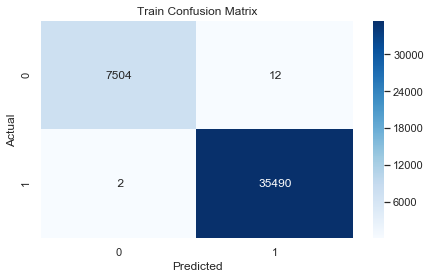

In [38]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

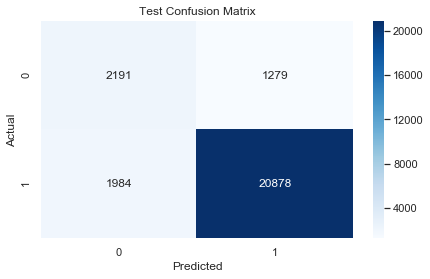

In [39]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

### Applying Logistic Regression with L2 regularization on BOW

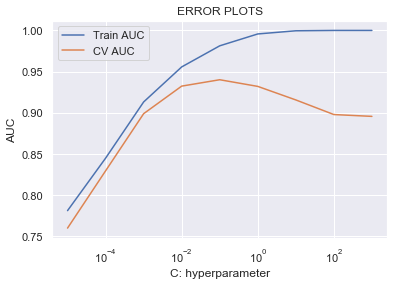

In [40]:
# Hyper parameter tuning to find best C
# Simple Cross validation

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
C = [10**-5,10**-4,10**-3,10**-2,10**-1,1,10,100,1000]
for i in C:
    LR=LogisticRegression(C=i,penalty='l2',class_weight='balanced',random_state=2,n_jobs=-1)
    LR.fit(X_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  LR.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  LR.predict_proba(X_cv_bow)[:,1]
    y_test_pred =  LR.predict_proba(X_test_bow)[:,1]

    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
plt.semilogx(C, train_auc,label='Train AUC')
plt.semilogx(C, cv_auc,label='CV AUC')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

From the plot,we can see that the best C value is at 10^-1

## Building Logistic Regression using best C value and L2 regilarization

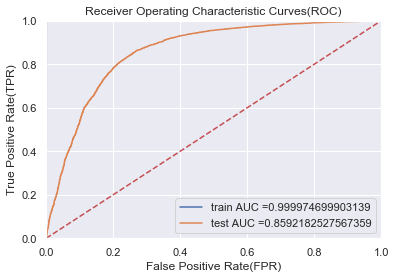

In [41]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
LR_L2=LogisticRegression(C=10**-1,penalty='l2',class_weight='balanced',random_state=3,n_jobs=-1)
LR_L2.fit(X_train_bow_std, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds_tr_bow = roc_curve(y_train, LR_L2.predict_proba(X_train_bow_std)[:,1])
test_fpr, test_tpr, thresholds_te_bow = roc_curve(y_test, LR_L2.predict_proba(X_test_bow_std)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()


In [42]:
# Finding the Weight vector(coefficients of features)

W_L2=LR_L2.coef_
W_L2

array([[ 1.92287854e-02,  1.58119540e-02,  6.52079074e-04, ...,
         2.77542844e-03, -2.12140652e-09,  8.90132726e-05]])

In [43]:
# Intercept
print("The Intercept is :",LR_L2.intercept_)

The Intercept is : [0.44719807]


In [44]:
from numpy import count_nonzero
print("Count of Non zeros :",count_nonzero(W_L2))
print("Total elements :",W_L2.size)
print("% of Non zero elements :",count_nonzero(W_L2) / float(W_L2.size)*100)# To see % of non zero elements

Count of Non zeros : 38523
Total elements : 38523
% of Non zero elements : 100.0


From the above calculations,we can see that L2 regularization does not make the coefficient values to zero
But,L1 regularization does.

## Plotting confusion matrix using seaborn

In [45]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr_bow, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.997239706575557 for threshold 0.376

Train confusion matrix:

[[ 7499    17]
 [   13 35479]]

Test confusion matrix:

[[ 2250  1220]
 [ 1640 21222]]


In [46]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

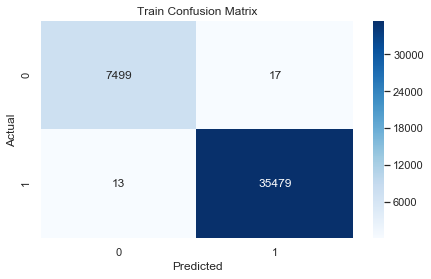

In [47]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

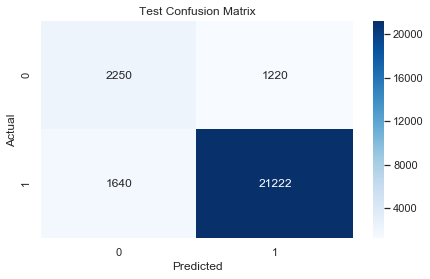

In [48]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

####  Performing pertubation test (multicollinearity check) on BOW

In [49]:
# Converting to BOW

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(dtype='float')
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)


print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)

After vectorizations
(43008, 38523) (43008,)
(18433, 38523) (18433,)
(26332, 38523) (26332,)


In [50]:
type(X_train_bow)

scipy.sparse.csr.csr_matrix

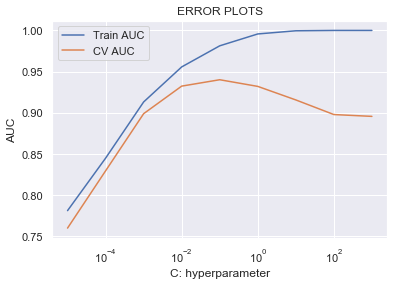

In [51]:
# Hyper parameter tuning to find best C
# Simple Cross validation

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
C = [10**-5,10**-4,10**-3,10**-2,10**-1,1,10,100,1000]
for i in C:
    LR=LogisticRegression(C=i,penalty='l2',class_weight='balanced',random_state=2,n_jobs=-1)
    LR.fit(X_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  LR.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  LR.predict_proba(X_cv_bow)[:,1]
    y_test_pred =  LR.predict_proba(X_test_bow)[:,1]

    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
plt.semilogx(C, train_auc,label='Train AUC')
plt.semilogx(C, cv_auc,label='CV AUC')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

From the above plot,we can see that the best C value is 10^-1

In [52]:
# Standardizing the data before applying Logistic Regression

from sklearn.preprocessing import StandardScaler
sc=StandardScaler(with_mean=False)
X_train_bow_std=sc.fit_transform(X_train_bow)
X_cv_bow_std=sc.transform(X_cv_bow)
X_test_bow_std=sc.transform(X_test_bow)

## Building logistic Regression with best C value on L2 regularization

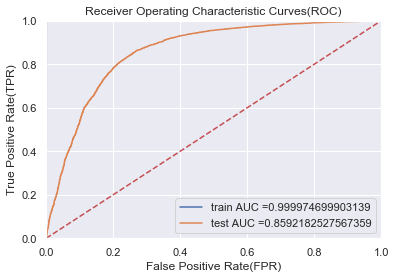

In [54]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
LR_L2=LogisticRegression(C=10**-1,penalty='l2',class_weight='balanced',random_state=3,n_jobs=-1)
LR_L2.fit(X_train_bow_std, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds_tr_bow = roc_curve(y_train, LR_L2.predict_proba(X_train_bow_std)[:,1])
test_fpr, test_tpr, thresholds_te_bow = roc_curve(y_test, LR_L2.predict_proba(X_test_bow_std)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()


In [55]:
# Finding the Weight vector(coefficients of features)

W1=LR_L2.coef_
W1

array([[ 1.92287854e-02,  1.58119540e-02,  6.52079074e-04, ...,
         2.77542844e-03, -2.12140652e-09,  8.90132726e-05]])

In [56]:
# Creating a new X_train by adding noise to the X_train_bow data

from scipy.sparse import csr_matrix
data = csr_matrix(X_train_bow)
noise= np.random.normal(loc=0.0, scale=0.001)
X_train_bow.data=X_train_bow.data+noise

In [57]:
X_train_bow

<43008x38523 sparse matrix of type '<class 'numpy.float64'>'
	with 1428438 stored elements in Compressed Sparse Row format>

In [58]:
X_train_bow_new=X_train_bow

In [59]:
X_train_bow_new.shape

(43008, 38523)

In [60]:
# Creating a new X_cv with noise to the X_cv_bow data

data = csr_matrix(X_cv_bow)
noise= np.random.normal(loc=0.0, scale=0.001)
X_cv_bow.data=X_cv_bow.data+noise

In [61]:
X_cv_bow

<18433x38523 sparse matrix of type '<class 'numpy.float64'>'
	with 622916 stored elements in Compressed Sparse Row format>

In [62]:
X_cv_bow_new=X_cv_bow

In [63]:
X_cv_bow_new.shape

(18433, 38523)

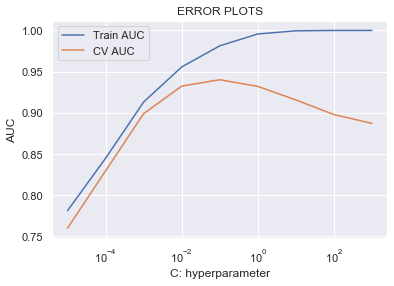

In [64]:
# Hyper parameter tuning to find best C
# Simple Cross validation

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
C = [10**-5,10**-4,10**-3,10**-2,10**-1,1,10,100,1000]
for i in C:
    LR=LogisticRegression(C=i,penalty='l2',class_weight='balanced',random_state=2,n_jobs=-1)
    LR.fit(X_train_bow_new, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  LR.predict_proba(X_train_bow_new)[:,1]
    y_cv_pred =  LR.predict_proba(X_cv_bow_new)[:,1]
    y_test_pred =  LR.predict_proba(X_test_bow)[:,1]

    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
plt.semilogx(C, train_auc,label='Train AUC')
plt.semilogx(C, cv_auc,label='CV AUC')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

From the above plot,we can see that the best C value is 10^-1

In [65]:
# Standardizing the data before applying Logistic Regression

from sklearn.preprocessing import StandardScaler
sc=StandardScaler(with_mean=False)
X_train_bow_new_std=sc.fit_transform(X_train_bow_new)
X_cv_bow_new_std=sc.transform(X_cv_bow_new)
X_test_bow_new_std=sc.transform(X_test_bow)

## Building a model on new data after adding noise

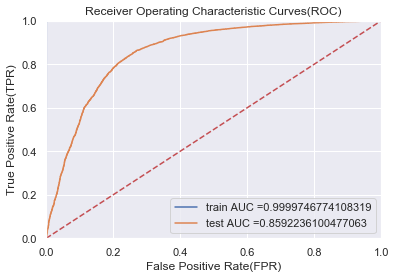

In [66]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
LR_L2=LogisticRegression(C=10**-1,penalty='l2',class_weight='balanced',random_state=3,n_jobs=-1)
LR_L2.fit(X_train_bow_new_std, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds_tr_bow = roc_curve(y_train, LR_L2.predict_proba(X_train_bow_new_std)[:,1])
test_fpr, test_tpr, thresholds_te_bow = roc_curve(y_test, LR_L2.predict_proba(X_test_bow_new_std)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()


In [67]:
# Finding the Weight vector(coefficients of features)

W2=LR_L2.coef_
W2

array([[ 1.92345430e-02,  1.57995042e-02,  6.52488491e-04, ...,
         2.77888051e-03, -1.65974426e-09,  8.77726918e-05]])

In [68]:
# Add a small eps value(to eliminate the divisible by zero error) to W1 and W2 i.e W1=W1+10^-6 and W2 = W2+10^-6

W1=W1+10**-6
W2=W2+10**-6

In [69]:
#  Find the % change between W1 and W2, percentage_change_vector = (| (W1-W2) / (W1) |)*100)

percentage_change_vector=abs((W1-W2)/(W1))*100

In [70]:
percentage_change_vector

array([[0.02994101, 0.07873162, 0.06269031, ..., 0.1243348 , 0.04626437,
        1.37821989]])

In [71]:
type(percentage_change_vector)

numpy.ndarray

In [72]:
percentage_change_vector.shape

(1, 38523)

In [73]:
# Calculating the Percentiles

percentile_0=np.percentile(percentage_change_vector,0)
percentile_10=np.percentile(percentage_change_vector,10)
percentile_20=np.percentile(percentage_change_vector,20)
percentile_30=np.percentile(percentage_change_vector,30)
percentile_40=np.percentile(percentage_change_vector,40)
percentile_50=np.percentile(percentage_change_vector,50)
percentile_60=np.percentile(percentage_change_vector,60)
percentile_70=np.percentile(percentage_change_vector,70)
percentile_80=np.percentile(percentage_change_vector,80)
percentile_90=np.percentile(percentage_change_vector,90)
percentile_100=np.percentile(percentage_change_vector,100)


In [74]:
print("percentile_0 is :",percentile_0)
print("percentile_10 is :",percentile_10)
print("percentile_20 is :",percentile_20)
print("percentile_30 is :",percentile_30)
print("percentile_40 is :",percentile_40)
print("percentile_50 is :",percentile_50)
print("percentile_60 is :",percentile_60)
print("percentile_70 is :",percentile_70)
print("percentile_80 is :",percentile_80)
print("percentile_90 is :",percentile_90)
print("percentile_100 is :",percentile_100)

percentile_0 is : 7.420579420660956e-07
percentile_10 is : 0.0168269253177337
percentile_20 is : 0.03592763699651512
percentile_30 is : 0.061956738018915054
percentile_40 is : 0.0962701186599703
percentile_50 is : 0.15112072005674618
percentile_60 is : 0.24366439938176873
percentile_70 is : 0.4338489338764495
percentile_80 is : 0.928061186154687
percentile_90 is : 3.9647701670265865
percentile_100 is : 368530.01179943985


From the percentiles we can see that there is sudden change from 90th percentile to 100th percentile.
Calculate percentiles from 90 to 100

In [75]:
print("percentile_90 is :",np.percentile(percentage_change_vector,90))
print("percentile_91 is :",np.percentile(percentage_change_vector,91))
print("percentile_92 is :",np.percentile(percentage_change_vector,92))
print("percentile_93 is :",np.percentile(percentage_change_vector,93))
print("percentile_94 is :",np.percentile(percentage_change_vector,94))
print("percentile_95 is :",np.percentile(percentage_change_vector,95))
print("percentile_96 is :",np.percentile(percentage_change_vector,96))
print("percentile_97 is :",np.percentile(percentage_change_vector,97))
print("percentile_98 is :",np.percentile(percentage_change_vector,98))
print("percentile_99 is :",np.percentile(percentage_change_vector,99))
print("percentile_100 is :",np.percentile(percentage_change_vector,100))


percentile_90 is : 3.9647701670265865
percentile_91 is : 4.922073823338348
percentile_92 is : 6.469166225787345
percentile_93 is : 8.782690597325946
percentile_94 is : 12.488238909853418
percentile_95 is : 20.904350577010206
percentile_96 is : 32.889965957232
percentile_97 is : 57.16915901336429
percentile_98 is : 98.89126706428775
percentile_99 is : 319.5324679513939
percentile_100 is : 368530.01179943985


From the above values,we can see that there is sudden change from 94 to 95 percentiles.
Therefore,the threshold value is 12.48 % beyond which the features are considered as Multi collinear.

In [76]:
# printing muilti collinear features

Multicollinear_features=percentage_change_vector>12.48

print(np.take(vectorizer.get_feature_names(),Multicollinear_features))

[['aa' 'aa' 'aa' ... 'aa' 'aa' 'aa']]


### Feature Importance on BOW

#### Top 10 important features of positive class

In [77]:
# Finding the indices of the weight vector(coefficients)
Pos_Class_features=W_L2[0].argsort()
Pos_Class_features

array([22728, 33963, 37930, ...,  8812,  3128, 14724], dtype=int64)

In [78]:
# Finding top 10 features of Positive Class
Pos_Class_features=Pos_Class_features[-10:]
Pos_Class_features

array([12180, 19756, 24754, 11589, 37826, 19741, 14424,  8812,  3128,
       14724], dtype=int64)

In [79]:
# printing the top 10 positive feature names

print(np.take(vectorizer.get_feature_names(),Pos_Class_features))

['favorite' 'loves' 'perfect' 'excellent' 'wonderful' 'love' 'good'
 'delicious' 'best' 'great']


In [80]:
features=np.take(vectorizer.get_feature_names(),Pos_Class_features)

In [81]:
# Creating a dataframe for the top 10 positive featues

Postive_features=pd.DataFrame(Pos_Class_features,columns=['Indices'])
Top_10_Positive_features=Postive_features.sort_values(by='Indices',ascending=True)

In [82]:
Top_10_Positive_features=Top_10_Positive_features.head(10)

In [83]:
Top_10_Positive_features['feature_names']=features

In [84]:
Top_10_Positive_features

,Indices,feature_names
8,3128,favorite
7,8812,loves
3,11589,perfect
0,12180,excellent
6,14424,wonderful
9,14724,love
5,19741,good
1,19756,delicious
2,24754,best
4,37826,great


#### Top 10 important features of negative class

In [85]:
Neg_Class_features=W_L2[0].argsort()
Neg_Class_features

array([22728, 33963, 37930, ...,  8812,  3128, 14724], dtype=int64)

In [86]:
# Finding top 10 features of Negative Class
Neg_Class_features=Neg_Class_features[0:10]
Neg_Class_features

array([22728, 33963, 37930,  9532, 16150, 34414, 34385,  9538,  4451,
        5825], dtype=int64)

In [87]:
# printing the top 10 negative feature names

print(np.take(vectorizer.get_feature_names(),Neg_Class_features))

['not' 'terrible' 'worst' 'disappointed' 'horrible' 'threw' 'thought'
 'disappointment' 'burnt' 'china']


In [88]:
Neg_features=np.take(vectorizer.get_feature_names(),Neg_Class_features)

In [89]:
# Creating a dataframe for the top 10 positive featues

Negative_features=pd.DataFrame(Neg_Class_features,columns=['Indices'])
Top_10_Negative_features=Negative_features.sort_values(by='Indices',ascending=True)

In [90]:
Top_10_Negative_features=Top_10_Negative_features.head(10)

In [91]:
Top_10_Negative_features['feature_names']=Neg_features

In [92]:
Top_10_Negative_features

,Indices,feature_names
8,4451,not
9,5825,terrible
3,9532,worst
7,9538,disappointed
4,16150,horrible
0,22728,threw
1,33963,thought
6,34385,disappointment
5,34414,burnt
2,37930,china


## Logistic Regression on TFIDF

###  Applying Logistic Regression with L1 regularization on TFIDF

In [93]:
tf_idf_vect = TfidfVectorizer(max_df=0.2)
tf_idf_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted Tfidf vectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)

After vectorizations
(43008, 38515) (43008,)
(18433, 38515) (18433,)
(26332, 38515) (26332,)


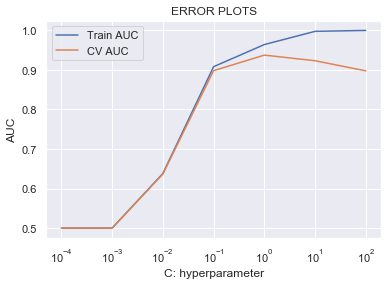

In [94]:
# Hyper parameter tuning to find best C
# Simple Cross validation

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
C = [10**-4,10**-3,10**-2,10**-1,1,10,100]
for i in C:
    LR_tfidf=LogisticRegression(C=i,penalty='l1',class_weight='balanced',random_state=3,n_jobs=-1)
    LR_tfidf.fit(X_train_tfidf, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  LR_tfidf.predict_proba(X_train_tfidf)[:,1]
    y_cv_pred =  LR_tfidf.predict_proba(X_cv_tfidf)[:,1]
    y_test_pred =  LR_tfidf.predict_proba(X_test_tfidf)[:,1]

    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
plt.semilogx(C, train_auc,label='Train AUC')
plt.semilogx(C, cv_auc,label='CV AUC')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

From the above plot,we can see that the best C value is 10^0

In [95]:
# Standardizing the data before applying Logistic Regression

sc=StandardScaler(with_mean=False)
X_train_tfidf_std=sc.fit_transform(X_train_tfidf)
X_cv_tfidf_std=sc.transform(X_cv_tfidf)
X_test_tfidf_std=sc.transform(X_test_tfidf)

## Building Logistic Regression using best C value and L1 regularization

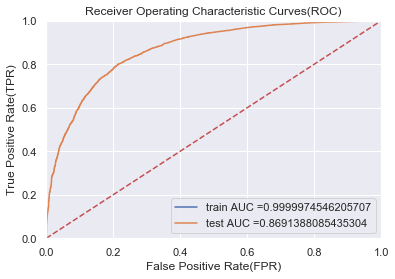

In [96]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
LR_tfidf1=LogisticRegression(C=10**0,penalty='l1',class_weight='balanced',random_state=2,n_jobs=-1)
LR_tfidf1.fit(X_train_tfidf_std, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds_tr_tfidf = roc_curve(y_train, LR_tfidf1.predict_proba(X_train_tfidf_std)[:,1])
test_fpr, test_tpr, thresholds_te_tfidf = roc_curve(y_test, LR_tfidf1.predict_proba(X_test_tfidf_std)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()


## Plotting Confusion Matrix using seaborn

In [97]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr_tfidf, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.9984520531787718 for threshold 0.518

Train confusion matrix:

[[ 7505    11]
 [   21 35471]]

Test confusion matrix:

[[ 2257  1213]
 [ 2066 20796]]


In [98]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

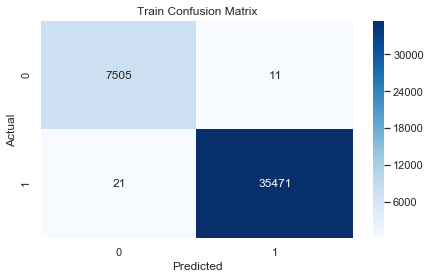

In [99]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

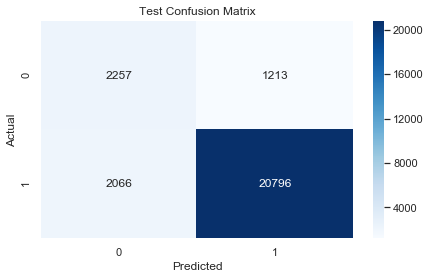

In [100]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

### Applying Logistic Regression with L2 regularization on TFIDF

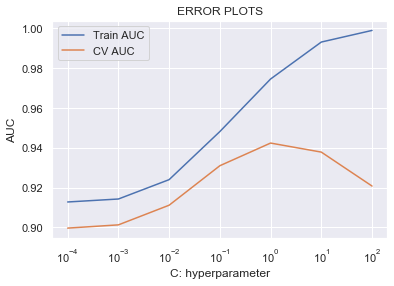

In [101]:
# Hyper parameter tuning to find best C
# Simple Cross validation

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
C = [10**-4,10**-3,10**-2,10**-1,1,10,100]
for i in C:
    LR_tfidf_L2=LogisticRegression(C=i,penalty='l2',class_weight='balanced',random_state=3,n_jobs=-1)
    LR_tfidf_L2.fit(X_train_tfidf, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  LR_tfidf_L2.predict_proba(X_train_tfidf)[:,1]
    y_cv_pred =  LR_tfidf_L2.predict_proba(X_cv_tfidf)[:,1]
    y_test_pred =  LR_tfidf_L2.predict_proba(X_test_tfidf)[:,1]

    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
plt.semilogx(C, train_auc,label='Train AUC')
plt.semilogx(C, cv_auc,label='CV AUC')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

From the above plot,we can see that the best C value is 10^0

## Building Logistic Regression using best C value and L2 regularization

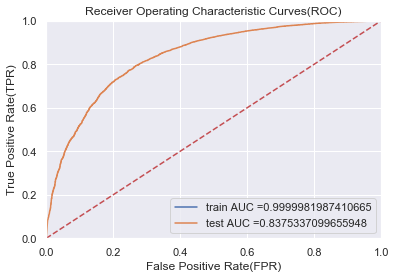

In [102]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
LR_L2_tfidf=LogisticRegression(C=10**0,penalty='l2',class_weight='balanced',random_state=3,n_jobs=-1)
LR_L2_tfidf.fit(X_train_tfidf_std, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds_tr_tfidf_L2 = roc_curve(y_train, LR_L2_tfidf.predict_proba(X_train_tfidf_std)[:,1])
test_fpr, test_tpr, thresholds_te_tfidf_L2 = roc_curve(y_test, LR_L2_tfidf.predict_proba(X_test_tfidf_std)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()


In [103]:
# Finding the Weight vector(coefficients of features)

W_L2_tfidf=LR_L2_tfidf.coef_
W_L2_tfidf[0]

array([ 3.56586801e-03,  2.09022314e-02,  5.28038527e-03, ...,
       -4.16898372e-05, -1.73998505e-05,  2.32016171e-02])

## Plotting Confusion Matrix using seaborn

In [104]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr_tfidf_L2, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.9984801873063375 for threshold 0.625

Train confusion matrix:

[[ 7497    19]
 [  812 34680]]

Test confusion matrix:

[[ 2532   938]
 [ 2246 20616]]


In [105]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

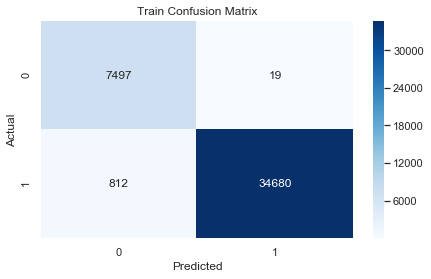

In [106]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

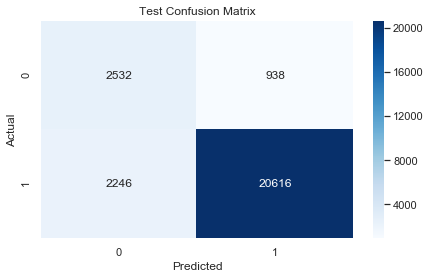

In [107]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

### Feature Importance on TFIDF

#### Top 10 important features of positive class

In [108]:
# Finding the indices of the weight vector(coefficients)
Pos_Class_features=W_L2_tfidf[0].argsort()
Pos_Class_features

array([33956,  9532, 37923, ..., 19738,  3128,  8812], dtype=int64)

In [109]:
# Finding top 10 features of Positive Class
Pos_Class_features=Pos_Class_features[-10:]
Pos_Class_features

array([31080, 19753, 31036,  1079, 24749, 11589, 37819, 19738,  3128,
        8812], dtype=int64)

In [110]:
# printing the top 10 positive feature names

print(np.take(tf_idf_vect.get_feature_names(),Pos_Class_features))

['snack' 'loves' 'smooth' 'amazing' 'perfect' 'excellent' 'wonderful'
 'love' 'best' 'delicious']


In [111]:
features=np.take(tf_idf_vect.get_feature_names(),Pos_Class_features)

In [112]:
# Creating a dataframe for the top 10 positive featues

Postive_features=pd.DataFrame(Pos_Class_features,columns=['Indices'])
Top_10_Positive_features=Postive_features.sort_values(by='Indices',ascending=True)

In [113]:
Top_10_Positive_features=Top_10_Positive_features.head(10)

In [114]:
Top_10_Positive_features['feature_names']=features

In [115]:
Top_10_Positive_features

,Indices,feature_names
3,1079,snack
8,3128,loves
9,8812,smooth
5,11589,amazing
7,19738,perfect
1,19753,excellent
4,24749,wonderful
2,31036,love
0,31080,best
6,37819,delicious


#### Top 10 important features of negative class

In [116]:
Neg_Class_features=W_L2_tfidf[0].argsort()
Neg_Class_features

array([33956,  9532, 37923, ..., 19738,  3128,  8812], dtype=int64)

In [117]:
# Finding top 10 features of Negative Class
Neg_Class_features=Neg_Class_features[0:10]
Neg_Class_features

array([33956,  9532, 37923, 16148, 34407, 34378, 28374, 16246, 22281,
        9538], dtype=int64)

In [118]:
# printing the top 10 negative feature names

print(np.take(tf_idf_vect.get_feature_names(),Neg_Class_features))

['terrible' 'disappointed' 'worst' 'horrible' 'threw' 'thought' 'return'
 'however' 'needless' 'disappointment']


In [119]:
Neg_features=np.take(tf_idf_vect.get_feature_names(),Neg_Class_features)

In [120]:
# Creating a dataframe for the top 10 positive featues

Negative_features=pd.DataFrame(Neg_Class_features,columns=['Indices'])
Top_10_Negative_features=Negative_features.sort_values(by='Indices',ascending=True)

In [121]:
Top_10_Negative_features=Top_10_Negative_features.head(10)

In [122]:
Top_10_Negative_features['feature_names']=Neg_features

In [123]:
Top_10_Negative_features

,Indices,feature_names
1,9532,terrible
9,9538,disappointed
3,16148,worst
7,16246,horrible
8,22281,threw
6,28374,thought
0,33956,return
5,34378,however
4,34407,needless
2,37923,disappointment


## Logistic Regression on AVG W2V

### Applying Logistic Regression with L1 regularization on AVG W2V

In [124]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

## Training W2V Model

In [125]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [126]:
# This line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

In [127]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12437
sample words  ['purchased', 'product', 'local', 'store', 'ny', 'kids', 'love', 'quick', 'easy', 'meal', 'put', 'toaster', 'oven', 'toast', 'min', 'ready', 'eat', 'strongly', 'recommend', 'partner', 'happy', 'tea', 'feeling', 'much', 'better', 'since', 'starting', 'drink', 'drinking', 'hot', 'normal', 'iced', 'chilled', 'likes', 'refreshing', 'nature', 'chocolate', 'amazing', 'taste', 'smell', 'found', 'new', 'one', 'finest', 'maple', 'syrups', 'ordered', 'enjoyed', 'bought', 'fancy']


## Converting Reviews into Numerical Vectors using W2V vectors

## Algorithm: Avg W2V

In [128]:
from tqdm import tqdm
import numpy as np

## Converting Train data text

In [129]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors_train = np.array(sent_vectors)


100%|███████████████████████████████████████████████████████████████████████████| 43008/43008 [01:38<00:00, 436.32it/s]


In [130]:
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

(43008, 50)
[-3.20370523e-02  4.62764978e-01  4.21436857e-01  3.19808862e-01
 -1.29780644e-03  5.40361896e-01  1.71534470e-02  1.15467129e-02
 -9.22939086e-01  6.13559461e-02 -3.31140354e-01 -3.18648917e-01
  9.35755927e-01 -3.17532958e-01  4.44146462e-01  5.46952465e-01
 -1.47372038e-01  2.81078770e-02  6.76591612e-02  3.84036895e-02
  3.20529911e-02  2.55332889e-01 -2.96884209e-01 -2.51273147e-02
 -4.88727157e-01  1.10794593e+00  4.57480974e-01 -4.04252861e-01
  4.13827013e-01 -1.33931701e+00  2.35223546e-01 -4.35684931e-01
  2.13911208e-01 -7.91792228e-03  4.62750891e-01 -9.87335887e-01
  2.09758687e-01 -9.12531132e-01 -2.18789128e-02 -5.47451936e-01
 -2.96220606e-01  8.56413182e-03  1.31112702e-01 -5.20363445e-01
 -5.69330075e-01  2.82969635e-01  5.20910203e-01  3.22563941e-01
 -2.85320564e-01  3.00440581e-01]


## Converting CV data text

In [131]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [132]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)


100%|███████████████████████████████████████████████████████████████████████████| 18433/18433 [00:44<00:00, 410.96it/s]


In [133]:
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

(18433, 50)
[-0.65081773  0.74190511 -0.15760173  0.08971106  0.98112839  0.34953524
  1.07321038  1.12029592 -0.72140856 -0.57708725  0.16846917  0.17689862
 -0.12934775 -1.36701571  1.39143182  0.55649616 -0.24043858  0.06849795
 -0.12281916  0.95532508  0.07829401 -0.93316176 -0.58841621 -0.32736092
 -0.05198739 -0.57189118 -0.46325344  0.04892105 -0.31643888 -0.54985495
  0.9364924  -1.16943771  0.24937879 -0.5683839   0.87695658  0.10937191
  0.54834543  0.86231828  0.22353082 -0.51697355  0.43646925  1.03620219
 -0.34196929  0.55365958  0.38139889  0.38855735 -0.40743393 -0.58211478
 -1.24841858  0.63583983]


## Converting Test data text

In [134]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [135]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|███████████████████████████████████████████████████████████████████████████| 26332/26332 [01:02<00:00, 424.15it/s]


(26332, 50)
[-0.03173416  0.14410643  0.07082545  0.44909718  0.60963372  0.16182207
  0.44823802  0.30504174 -0.51507403 -0.16474915 -0.03991485 -0.10464591
  0.43285781 -0.5901693   0.43094061  0.2185985   0.12587365  0.30406537
 -0.11313716  0.05515283  0.26754395  0.01400946 -0.42279572 -0.1721616
  0.13103976  0.04916044  0.19040196 -0.12106231  0.02826633 -0.58653374
  0.24022598 -0.33534105  0.13342125 -0.18728616  0.06724371 -0.65822929
  0.18293284  0.3212399  -0.36031517 -0.13183822  0.03085821  0.02545907
  0.11982632 -0.12520813 -0.42165304  0.60075704  0.12714827  0.28575854
 -0.32734979 -0.1118091 ]


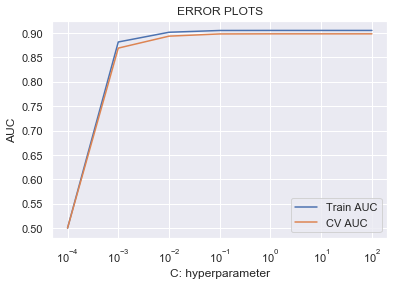

In [136]:
# Hyper parameter tuning to find best C
# Simple Cross validation

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
C = [10**-4,10**-3,10**-2,10**-1,1,10,100]
for i in C:
    LR_avgw2v=LogisticRegression(C=i,penalty='l1',class_weight='balanced',random_state=4,n_jobs=-1)
    LR_avgw2v.fit(sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  LR_avgw2v.predict_proba(sent_vectors_train)[:,1]
    y_cv_pred =  LR_avgw2v.predict_proba(sent_vectors_cv)[:,1]
    y_test_pred =  LR_avgw2v.predict_proba(sent_vectors_test)[:,1]

    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
plt.semilogx(C, train_auc,label='Train AUC')
plt.semilogx(C, cv_auc,label='CV AUC')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

From the above plot,we can see that the best C value is 10^-2

In [137]:
# Standardizing the data before applying Logistic Regression

sc=StandardScaler(with_mean=False)
X_train_avgw2v_std=sc.fit_transform(sent_vectors_train)
X_cv_avgv2v_std=sc.transform(sent_vectors_cv)
X_test_avgw2v_std=sc.transform(sent_vectors_test)

## Building Logistic Regression using best C value and L1 regularization

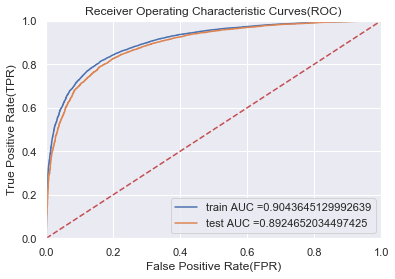

In [138]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
LR_L1=LogisticRegression(C=10**-2,penalty='l1',class_weight='balanced',random_state=4,n_jobs=-1)
LR_L1.fit(X_train_avgw2v_std, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds_tr_avgw2v = roc_curve(y_train, LR_L1.predict_proba(X_train_avgw2v_std)[:,1])
test_fpr, test_tpr, thresholds_te_avgw2c = roc_curve(y_test, LR_L1.predict_proba(X_test_avgw2v_std)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()


In [139]:
# Finding the Weight vector(coefficients of features)

W=LR_L1.coef_
W

array([[ 0.00000000e+00,  0.00000000e+00,  5.40923800e-01,
         1.81822952e-01, -1.98570444e-02, -2.72247275e-01,
         1.61608226e-01,  1.02456617e-01, -3.19485368e-01,
        -1.03819648e-01,  0.00000000e+00,  4.75730958e-02,
         1.00520473e-01,  1.68482321e-02,  2.74390886e-01,
        -1.62945597e-01, -9.26966599e-02,  1.28105768e-01,
        -2.09194077e-01,  0.00000000e+00,  1.43436619e-01,
         1.07672479e-01, -3.80541698e-01,  5.43922192e-01,
        -2.27602722e-04,  4.01389658e-01,  0.00000000e+00,
        -3.58105780e-02,  0.00000000e+00, -2.13329079e-02,
         0.00000000e+00,  1.86700021e-01,  3.36625223e-01,
         1.82993526e-02,  3.69921856e-01, -4.92955973e-01,
         1.02732555e-01, -4.80361913e-01,  6.11739647e-01,
        -1.12125727e-01,  0.00000000e+00, -1.12635229e-01,
         4.25556059e-02,  1.47784679e-01,  1.07820266e-01,
        -1.00610138e-01,  1.51714014e-01, -1.17451618e-03,
         1.82172855e-02,  3.04792103e-01]])

## Plotting Confusion Matrix using seaborn

In [141]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr_avgw2v, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.6820665258568264 for threshold 0.491

Train confusion matrix:

[[ 6319  1197]
 [ 6650 28842]]

Test confusion matrix:

[[ 2771   699]
 [ 3972 18890]]


In [142]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

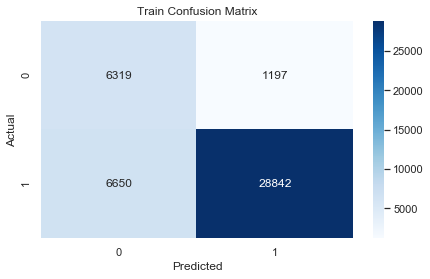

In [143]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

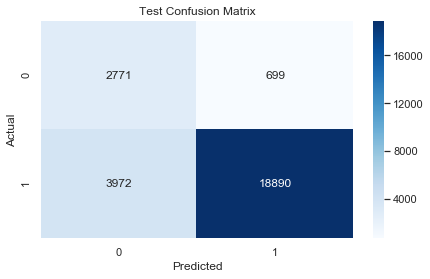

In [144]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

###  Applying Logistic Regression with L2 regularization on AVG W2V

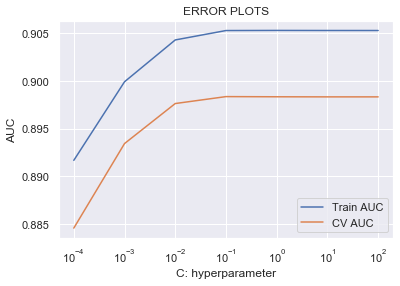

In [145]:
# Hyper parameter tuning to find best C
# Simple Cross validation

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
C = [10**-4,10**-3,10**-2,10**-1,1,10,100]
for i in C:
    LR_L2=LogisticRegression(C=i,penalty='l2',class_weight='balanced',random_state=4,n_jobs=-1)
    LR_L2.fit(sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  LR_L2.predict_proba(sent_vectors_train)[:,1]
    y_cv_pred =  LR_L2.predict_proba(sent_vectors_cv)[:,1]
    y_test_pred =  LR_L2.predict_proba(sent_vectors_test)[:,1]

    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
plt.semilogx(C, train_auc,label='Train AUC')
plt.semilogx(C, cv_auc,label='CV AUC')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

From the above plot,we can see that the best C value is between 10^-1 to 10^2

## Building Logistic Regression using best C value and L2 regularization

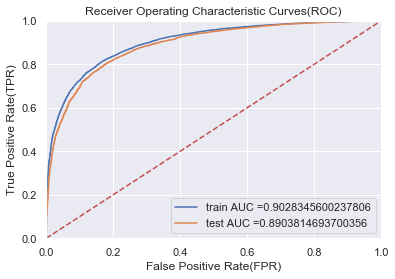

In [146]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
LR_L2_avgw2v=LogisticRegression(C=10**-1,penalty='l2',class_weight='balanced',random_state=4,n_jobs=-1)
LR_L2_avgw2v.fit(X_train_avgw2v_std, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds_tr_L2_avgw2v = roc_curve(y_train, LR_L2.predict_proba(X_train_avgw2v_std)[:,1])
test_fpr, test_tpr, thresholds_te_L2_avgw2v = roc_curve(y_test, LR_L2.predict_proba(X_test_avgw2v_std)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()


In [147]:
# Finding the Weight vector(coefficients of features)

W_L2=LR_L2_avgw2v.coef_
W_L2

array([[ 0.07621058, -0.03333813,  0.56236986,  0.30995388, -0.03018718,
        -0.33815829,  0.36722447,  0.13306236, -0.31504454, -0.2373117 ,
         0.0727037 ,  0.12598279,  0.26300974,  0.04502326,  0.30570312,
        -0.18859381, -0.12984568,  0.20339997, -0.28931328,  0.00174024,
         0.18851959,  0.12279978, -0.3400996 ,  0.53079803, -0.02089   ,
         0.41411791, -0.00877637, -0.10831698, -0.00098406, -0.19751093,
         0.06766439,  0.11135695,  0.36410399,  0.09046634,  0.35702293,
        -0.52964927,  0.09853711, -0.528618  ,  0.6702437 , -0.12618888,
         0.01335073, -0.29691141,  0.0721171 ,  0.20228332,  0.16179653,
        -0.11859191,  0.17880721, -0.04761085,  0.05786683,  0.40801435]])

In [148]:
# Intercept
print("The Intercept is :",LR_L2_avgw2v.intercept_)

The Intercept is : [-0.71001655]


## Plotting confusion matrix using seaborn

In [149]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr_L2_avgw2v, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.6773280527593953 for threshold 0.813

Train confusion matrix:

[[ 7268   248]
 [15820 19672]]

Test confusion matrix:

[[ 3291   179]
 [ 9811 13051]]


In [150]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

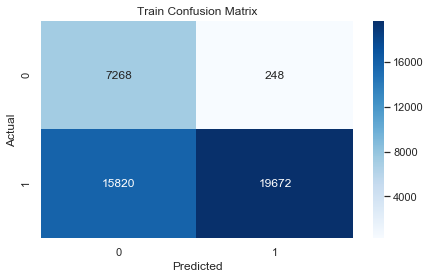

In [151]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

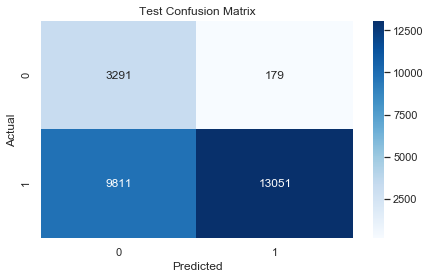

In [152]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

## Logistic Regression on TFIDF W2V

### Applying Logistic Regression with L1 regularization on TFIDF W2V

## Converting Train data to Tfidf_w2v

In [153]:
model = TfidfVectorizer(norm='l1')
tf_idf_matrix_train = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [154]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 43008/43008 [24:00<00:00, 29.86it/s]


In [155]:
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)

In [156]:
print(tfidf_sent_vectors_train.shape)
print(tfidf_sent_vectors_train[0])

(43008, 50)
[-0.11468765  0.53929187  0.33050376  0.29882723 -0.04431943  0.46477625
 -0.01317089  0.0726452  -0.76069265  0.01897565 -0.12426157 -0.24379357
  0.73623014 -0.31595386  0.40861487  0.53556974 -0.1202627   0.01220961
  0.05116267  0.07738972  0.08814006  0.2387345  -0.23631574 -0.00895654
 -0.24783768  0.84588664  0.43177974 -0.31540568  0.47375931 -1.25890897
  0.19714973 -0.34810716  0.19661162 -0.10126659  0.47940426 -0.88906699
  0.14093368 -0.96706428 -0.0237498  -0.51315951 -0.19216137 -0.16291684
  0.07059549 -0.42518767 -0.61923915  0.22206692  0.46061774  0.07914302
 -0.10760649  0.32161547]


## Converting CV data to tfidf-w2v

In [157]:
model_cv = TfidfVectorizer(norm='l1')
tf_idf_matrix_cv = model_cv.fit_transform(X_cv)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_cv = dict(zip(model_cv.get_feature_names(), list(model_cv.idf_)))

In [158]:
# TF-IDF weighted Word2Vec
tfidf_feat = model_cv.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_cv[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 18433/18433 [06:12<00:00, 49.49it/s]


In [159]:
tfidf_sent_vectors_cv = np.array(tfidf_sent_vectors_cv)

In [160]:
print(tfidf_sent_vectors_cv.shape)
print(tfidf_sent_vectors_cv[0])

(18433, 50)
[-0.6580718   0.75951197 -0.1897205   0.09325457  0.98006393  0.20174962
  0.96740814  1.05793585 -0.70470798 -0.7768067   0.06873723  0.13275148
 -0.09278451 -1.32494797  1.51927345  0.53183642 -0.25485562  0.34408875
 -0.21535245  0.9955718  -0.05405146 -0.9831963  -0.62560827 -0.1780185
 -0.07616013 -0.42636065 -0.48410017  0.01355597 -0.38740743 -0.50175904
  0.65301284 -0.98713206  0.10460599 -0.53957188  1.02028528 -0.00206246
  0.36748773  0.64836432  0.17992795 -0.43306604  0.40294989  0.73154018
 -0.19718241  0.48396753  0.59517506  0.25115136 -0.19515558 -0.78876752
 -1.20384569  0.51237516]


## Converting Test data to tfidf-w2v

In [161]:
model_test = TfidfVectorizer(norm='l1')
tf_idf_matrix_test = model_test.fit_transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_test = dict(zip(model_test.get_feature_names(), list(model_test.idf_)))

In [162]:
# TF-IDF weighted Word2Vec
tfidf_feat = model_test.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_test[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 26332/26332 [10:49<00:00, 40.55it/s]


In [163]:
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)

In [164]:
print(tfidf_sent_vectors_test.shape)
print(tfidf_sent_vectors_test[0])

(26332, 50)
[-0.1111492   0.06601213  0.06022837  0.37535626  0.48179236  0.19248144
  0.54936712  0.22380498 -0.40593098 -0.2243921  -0.09517443  0.00787092
  0.29472493 -0.55368951  0.4556903   0.23925988  0.12421204  0.37889202
 -0.11170153 -0.07405166  0.19316205  0.06304496 -0.31864408 -0.1401556
  0.23955365 -0.00883379  0.20823879 -0.11587121 -0.02007238 -0.51477781
  0.17835992 -0.23602745  0.15745767 -0.32368552  0.14224254 -0.52700235
  0.05025398  0.34541366 -0.34466636 -0.02563577  0.21721939 -0.04621781
  0.10164129 -0.11743871 -0.45675481  0.48683997  0.24531375  0.20105659
 -0.29046136 -0.18629183]


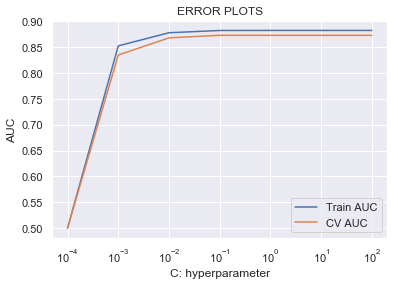

In [165]:
# Hyper parameter tuning to find best C
# Simple Cross validation

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
C = [10**-4,10**-3,10**-2,10**-1,1,10,100]
for i in C:
    LR_L1=LogisticRegression(C=i,penalty='l1',class_weight='balanced',random_state=4,n_jobs=-1)
    LR_L1.fit(tfidf_sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  LR_L1.predict_proba(tfidf_sent_vectors_train)[:,1]
    y_cv_pred =  LR_L1.predict_proba(tfidf_sent_vectors_cv)[:,1]
    y_test_pred =  LR_L1.predict_proba(tfidf_sent_vectors_test)[:,1]

    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
plt.semilogx(C, train_auc,label='Train AUC')
plt.semilogx(C, cv_auc,label='CV AUC')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

From the above plot,we can see that the best C value is 10^-1

In [166]:
# Standardizing the data before applying Logistic Regression

sc=StandardScaler(with_mean=False)
X_train_tfidfavgw2v_std=sc.fit_transform(tfidf_sent_vectors_train)
X_cv_tfidfavgv2v_std=sc.transform(tfidf_sent_vectors_cv)
X_test_tfidfavgw2v_std=sc.transform(tfidf_sent_vectors_test)

## Building Logistic Regression using best C value and L1 regularization

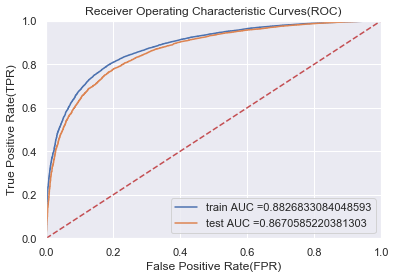

In [167]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
LR_L1_tfidfavgw2v=LogisticRegression(C=10**-1,penalty='l1',class_weight='balanced',random_state=4,n_jobs=-1)
LR_L1_tfidfavgw2v.fit(X_train_tfidfavgw2v_std, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds_tr_L1_tfidfavgw2v = roc_curve(y_train, LR_L1_tfidfavgw2v.predict_proba(X_train_tfidfavgw2v_std)[:,1])
test_fpr, test_tpr, thresholds_te_L1_tfidfavgw2v = roc_curve(y_test, LR_L1_tfidfavgw2v.predict_proba(X_test_tfidfavgw2v_std)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()


## Plotting Confusion Matrix using seaborn

In [168]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr_L1_tfidfavgw2v, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.6492901547812617 for threshold 0.491

Train confusion matrix:

[[ 6139  1377]
 [ 7302 28190]]

Test confusion matrix:

[[ 2693   777]
 [ 4649 18213]]


In [169]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

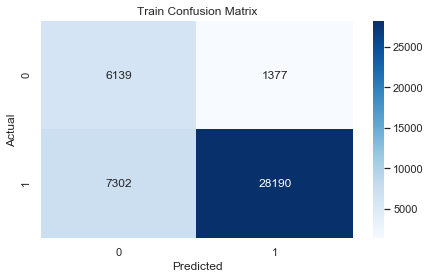

In [170]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

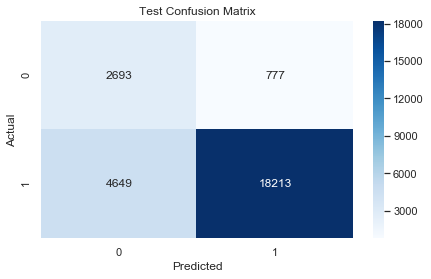

In [171]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

### Applying Logistic Regression with L2 regularization on TFIDF W2V

## Converting Train data to Tfidf_w2v

In [172]:
model = TfidfVectorizer(norm='l2')
tf_idf_matrix_train = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [173]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 43008/43008 [23:41<00:00, 30.25it/s]


In [174]:
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)

In [175]:
print(tfidf_sent_vectors_train.shape)
print(tfidf_sent_vectors_train[0])

(43008, 50)
[-0.11468765  0.53929187  0.33050376  0.29882723 -0.04431943  0.46477625
 -0.01317089  0.0726452  -0.76069265  0.01897565 -0.12426157 -0.24379357
  0.73623014 -0.31595386  0.40861487  0.53556974 -0.1202627   0.01220961
  0.05116267  0.07738972  0.08814006  0.2387345  -0.23631574 -0.00895654
 -0.24783768  0.84588664  0.43177974 -0.31540568  0.47375931 -1.25890897
  0.19714973 -0.34810716  0.19661162 -0.10126659  0.47940426 -0.88906699
  0.14093368 -0.96706428 -0.0237498  -0.51315951 -0.19216137 -0.16291684
  0.07059549 -0.42518767 -0.61923915  0.22206692  0.46061774  0.07914302
 -0.10760649  0.32161547]


## Converting CV data to tfidf-w2v

In [176]:
# TF-IDF weighted Word2Vec
tfidf_feat = model_cv.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_cv[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 18433/18433 [05:39<00:00, 54.29it/s]


In [177]:
tfidf_sent_vectors_cv = np.array(tfidf_sent_vectors_cv)

In [178]:
print(tfidf_sent_vectors_cv.shape)
print(tfidf_sent_vectors_cv[0])

(18433, 50)
[-0.6580718   0.75951197 -0.1897205   0.09325457  0.98006393  0.20174962
  0.96740814  1.05793585 -0.70470798 -0.7768067   0.06873723  0.13275148
 -0.09278451 -1.32494797  1.51927345  0.53183642 -0.25485562  0.34408875
 -0.21535245  0.9955718  -0.05405146 -0.9831963  -0.62560827 -0.1780185
 -0.07616013 -0.42636065 -0.48410017  0.01355597 -0.38740743 -0.50175904
  0.65301284 -0.98713206  0.10460599 -0.53957188  1.02028528 -0.00206246
  0.36748773  0.64836432  0.17992795 -0.43306604  0.40294989  0.73154018
 -0.19718241  0.48396753  0.59517506  0.25115136 -0.19515558 -0.78876752
 -1.20384569  0.51237516]


## Converting Test data to tfidf-w2v

In [179]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [180]:
model_test = TfidfVectorizer(norm='l2')
tf_idf_matrix_test = model_test.fit_transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_test = dict(zip(model_test.get_feature_names(), list(model_test.idf_)))

In [181]:
# TF-IDF weighted Word2Vec
tfidf_feat = model_test.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_test[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 26332/26332 [09:01<00:00, 37.01it/s]


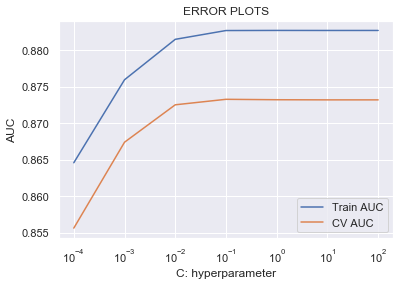

In [182]:
# Hyper parameter tuning to find best C
# Simple Cross validation

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
C = [10**-4,10**-3,10**-2,10**-1,1,10,100]
for i in C:
    LR_L1=LogisticRegression(C=i,penalty='l2',class_weight='balanced',random_state=4,n_jobs=-1)
    LR_L1.fit(tfidf_sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  LR_L1.predict_proba(tfidf_sent_vectors_train)[:,1]
    y_cv_pred =  LR_L1.predict_proba(tfidf_sent_vectors_cv)[:,1]
    y_test_pred =  LR_L1.predict_proba(tfidf_sent_vectors_test)[:,1]

    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
plt.semilogx(C, train_auc,label='Train AUC')
plt.semilogx(C, cv_auc,label='CV AUC')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

From the above plot,we can see that the best C value is between 10^-1 and 10^2

In [183]:
# Standardizing the data before applying Logistic Regression

sc=StandardScaler(with_mean=False)
X_train_tfidfavgw2v_std=sc.fit_transform(tfidf_sent_vectors_train)
X_cv_tfidfavgv2v_std=sc.transform(tfidf_sent_vectors_cv)
X_test_tfidfavgw2v_std=sc.transform(tfidf_sent_vectors_test)

## Building Logistic Regression using best C value and L2 regularization

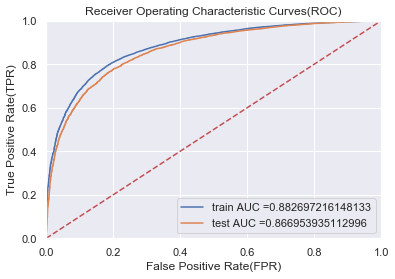

In [184]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
LR_L2_tfidfavgw2v=LogisticRegression(C=10**-1,penalty='l2',class_weight='balanced',random_state=4,n_jobs=-1)
LR_L2_tfidfavgw2v.fit(X_train_tfidfavgw2v_std, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds_tr_L2_tfidfavgw2v = roc_curve(y_train, LR_L2_tfidfavgw2v.predict_proba(X_train_tfidfavgw2v_std)[:,1])
test_fpr, test_tpr, thresholds_te_L2_tfidfavgw2v = roc_curve(y_test, LR_L2_tfidfavgw2v.predict_proba(X_test_tfidfavgw2v_std)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Receiver Operating Characteristic Curves(ROC)")
plt.show()


## Plotting Confusion Matrix using seaborn

In [185]:

print()
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds_tr_L2_tfidfavgw2v, train_fpr, train_tpr)
print("Train confusion matrix:")
print()
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print()
print("Test confusion matrix:")
print()
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))


The maximum value of tpr*(1-fpr) 0.6492198438290135 for threshold 0.487

Train confusion matrix:

[[ 6110  1406]
 [ 7194 28298]]

Test confusion matrix:

[[ 2683   787]
 [ 4588 18274]]


In [186]:
Train_Confusion_Matrix=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_Confusion_Matrix=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
df_Train=pd.DataFrame(Train_Confusion_Matrix,columns=np.unique(y_train), index = np.unique(y_train))
df_Test=pd.DataFrame(Test_Confusion_Matrix,columns=np.unique(y_test), index = np.unique(y_test))
df_Train.index.name = 'Actual'
df_Train.columns.name = 'Predicted'
df_Test.index.name = 'Actual'
df_Test.columns.name = 'Predicted'


Text(0.5, 1, 'Train Confusion Matrix')

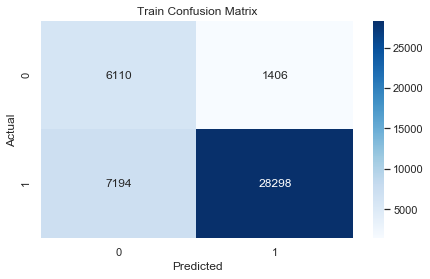

In [187]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Train, cmap="Blues", annot=True,fmt='2d')
plt.title("Train Confusion Matrix")

Text(0.5, 1, 'Test Confusion Matrix')

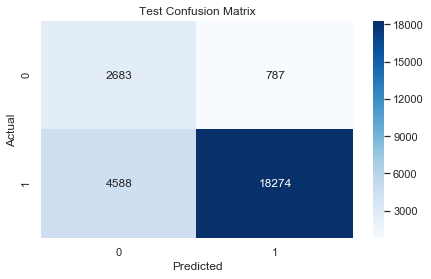

In [188]:
plt.figure(figsize = (7,4))
sns.set(font_scale=1)#for label size
sns.heatmap(df_Test, cmap="Blues", annot=True,fmt='2d')
plt.title("Test Confusion Matrix")

# Conclusions

In [193]:
from prettytable import PrettyTable

In [194]:
x=PrettyTable()

In [195]:
x.field_names=['Vectorizer','Regularization','Hyper Parameter_C','AUC']

In [196]:
x.add_row(['BOW','L1',10**-1,0.9059*100])
x.add_row(['BOW','L2',10**-1,0.8592*100])
x.add_row(['TFIDF','L1',10**0,0.8691*100])
x.add_row(['TFIDF','L2',10**0,0.8375*100])
x.add_row(['AVGW2V','L1',10**-2,0.8924*100])
x.add_row(['AVGW2V','L2',10**-1,0.8903*100])
x.add_row(['TFIDF_AVGW2V','L1',10**-1,0.8670*100])
x.add_row(['TFIDF_AVGW2V','L2',10**0,0.8669*100])

In [197]:
print(x)

+--------------+----------------+-------------------+-------+
|  Vectorizer  | Regularization | Hyper Parameter_C |  AUC  |
+--------------+----------------+-------------------+-------+
|     BOW      |       L1       |        0.1        | 90.59 |
|     BOW      |       L2       |        0.1        | 85.92 |
|    TFIDF     |       L1       |         1         | 86.91 |
|    TFIDF     |       L2       |         1         | 83.75 |
|    AVGW2V    |       L1       |        0.01       | 89.24 |
|    AVGW2V    |       L2       |        0.1        | 89.03 |
| TFIDF_AVGW2V |       L1       |        0.1        |  86.7 |
| TFIDF_AVGW2V |       L2       |         1         | 86.69 |
+--------------+----------------+-------------------+-------+
